In [ ]:
from pathlib import Path
import requests

    1. Path and request module are used for fetching data from src.
    2. The data is a zip file which contains the MNIST dataset in
       pickle format.
    3. Pickle format is used for serializing data(binary stream)
       objects in python.

In [ ]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir( parents=True, exist_ok = True )

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():

    content = requests.get(URL+FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

Here we use gzip and pickle module to unzip and access the dataset.

In [ ]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(),"rb") as f:
        ((x_train,y_train) ,(x_valid,y_valid),_) = pickle.load(f,
            encoding= "latin-1")


    1. The dataset are pixels of images but they are stored as a
       flattened single vector or array with 784(28*28) columns or
       entries. 
    2. Inorder to plot the image we need to reshape it to 2D.
    3. There are 50,000 images or instances.

(50000, 784)


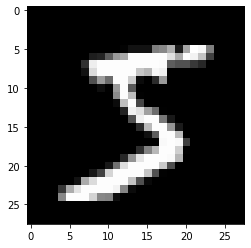

In [ ]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape(28,28),cmap = "gray")
print(x_train.shape)

1. PyTorch works on torch.tensor data-objects but our data is an
   array. Hence we need to construct tensor object from our dataset.
2. Torch.tensor is a module which does this,  hence we use map and
   (tensor module & corresponding array objects) to replace the array
   storing variables with tensor objects. 

In [ ]:
import torch

x_train , y_train , x_valid , y_valid = map(
        torch.tensor , (x_train,y_train,x_valid,y_valid)
)
n,c = x_train.shape

print(x_train,y_train)
print(x_train.shape)
print(y_train.min(),y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Model (with tensor operations)

### Initializing weights &amp; biases

Dimensions :

   1. x (feature-vector) : (64,784) (instances , features or pixels)
   2. y (Label) : (64,1) (instances , labels)
   3. W (weights) : (784,10) ( features or x[1] , neurons in layer)
   4. b (bias) : (1,10)
   5. Z (activation) : (1,10)    

In [ ]:
import math

weights = torch.randn(784,10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10,requires_grad= True)

### Activation Function

1. What we're doing here is basically building a neural net for a classification problem with 10 outputs (0-9).
2. This doesn't have hidden layers.
3. The activation function used here is log-softmax.
4. This provides probability of each class for a input/instance.



In [ ]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [ ]:
bs = 64

xb = x_train[0:bs]
preds = model(xb)
preds[0] , preds.shape
print(preds[0],preds.shape)

tensor([-1.9614, -2.5732, -1.9593, -2.7612, -1.8503, -1.8847, -2.3464, -2.6803,
        -2.9172, -2.9669], grad_fn=<SelectBackward>) torch.Size([64, 10])


### Loss Function

1. The dimension of our prediction is [64,10]. Which means it contains the probability of all the 10
possible outputs.
2. We just want to consider the probability corresponding to the actual output of the instance.Hence we use indexing on the preds(tensor) . 
3. preds(range(0,64),target) : 
    1. The first arg is for rows ,here it is range of 63 indexes. 
    2. The second arg is for columns, here we provide the target(y) itself. It contains the output of the instances which also fortunately works as index. 
    3. So for e.g, if the value in y is 5 for a instance we can look at 5th index in the preds[tensor] for that instance to get the probability of the output being 5. 
4. Lastly we take the mean of the obtained tensor , this is our loss.

In [ ]:
def nll( g,target):
    return -g[range(target.shape[0]), target].mean()
    

loss_func = nll

In [ ]:
yb = y_train[0:bs]
print(loss_func(preds,yb))

tensor(2.3834, grad_fn=<NegBackward>)


### Accuracy

1. Pick the index with largest probabilty for an instance from preds.
2. Compare if the index matches with the ouput in the target array for same instance.
3. This comparison returns a tensor with boolean values for matches and non-matches. Converting to float and then taking mean gives the accuracy for this random model.

In [ ]:
def accuracy(out,yb):

    preds = torch.argmax(out,dim=1)
    
    return (preds == yb).float().mean()

In [ ]:
print(accuracy(preds, yb))

tensor(0.0312)


### Minimal neural network

1. W and b are tensors with gradients enabled. Hence any function or variable that use these tensors will have backward() enabled.
2. https://discuss.pytorch.org/t/what-does-the-backward-function-do/9944/2 (It computes gradients of calling tensor w.r.t all the variables with grad = True)
3. Each tensor T with grad enabled will have it's gradient computed in previous step accesible by using (T.grad)
4. We then update these tensors by using above grad value and learning rate.
5. Lastly , clear the value so that grad value doesn't add up after each pass.

In [ ]:
lr = 0.5
epochs = 2

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):

        start_i = i*bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred,yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()


In [ ]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0801, grad_fn=<NegBackward>) tensor(1.)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a5eebfae-950c-452c-bcd1-02b41e6a5850' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>